# Step Off Waveform Magnetic Dipole Sounding over a Sphere

In this notebook, we will simulate an TDEM sounding over a conductive sphere. A cylindrical mesh and the [SimPEG](http://simpeg.xyz) Electromanetics module is used to perform the simulation. 

For more on SimPEG and SimPEG.EM see:

- [(Cockett et al., 2015)](http://www.sciencedirect.com/science/article/pii/S009830041530056X): *SimPEG: An open source framework for simulation and gradient based parameter estimation in geophysical applications*
- [(Heagy et al., 2016)](https://arxiv.org/abs/1610.00804): *A framework for simulation and inversion in electromagnetics*


## Setup

An inductive loop transmitter is centered over an electrically conductive sphere (radius 30m). The transmitter is 20m above the surface, and the center of the sphere is 50m below the surface. A coil receiver is offset by 8m horizontally from the transmitter. 

<img src="https://raw.githubusercontent.com/simpeg/em_notebooks/master/images/cylsetup.png" width=60%>

## Getting Started: Package Imports

- [NumPy](http://www.numpy.org/), [SciPy](https://www.scipy.org/) and [Matplotlib](http://matplotlib.org/) are core Python packages that can be installed when you install python with a distribution such as [Anaconda](https://www.continuum.io/downloads). 

- [SimPEG](http://simpeg.xyz) is a Simulation and Inversion package for geophysics

In [1]:
# Basic python packages
import numpy as np 
import matplotlib.pyplot as plt
from scipy.constants import mu_0

# Modules of SimPEG we will use for forward modelling
from SimPEG import Mesh, Utils, Maps
from SimPEG.EM import TDEM

# Try importing PardisoSolver from pymatsolver (https://github.com/rowanc1/pymatsolver) 
# otherwise, use SolverLU from SimPEG 
try: 
    from pymatsolver import PardisoSolver as Solver
except ImportError:
    from SimPEG import SolverLU as Solver

# Set a nice colormap! 
plt.set_cmap(plt.get_cmap('viridis'))

%matplotlib inline

## Model Parameters

We define a 
- resistive halfspace and 
- conductive sphere 
   - radius of 30m 
   - center is 50m below the surface

In [2]:
# electrical conductivities in S/m
sig_halfspace = np.r_[1e-8, 1e-4, 1e-2, 1e-1, 1e0]
sig_sphere = 2
sig_air = 1e-8

In [3]:
# depth to center, radius in m
sphere_z = -50.
sphere_radius = 30. 

## Survey Parameters

- Transmitter and receiver 20m above the surface 
- Receiver offset from transmitter by 8m horizontally
- 25 frequencies, logaritmically between $10$ Hz and $10^5$ Hz

In [4]:
boom_height = 20. 
rx_offset = 8. 
time = 1e-4

# source and receiver location in 3D space
src_loc = np.r_[0., 0., boom_height]
rx_loc = np.atleast_2d(np.r_[rx_offset, 0., boom_height])

In [5]:
# print the min and max skin depths to make sure mesh is fine enough and 
# extends far enough 

print('min diffusion distance ', 1.28*np.sqrt(time/(sig_halfspace.max()*mu_0)))
print('max diffusion distance ', 1.28*np.sqrt(time/(sig_halfspace.min()*mu_0)))

('min diffusion distance ', 11.418394343377736)
('max diffusion distance ', 114183.94343377736)


## Mesh

Here, we define a cylindrically symmetric tensor mesh. 

The figure below shows a cell in a cartesian mesh (a) and a cylindrically symmetric mesh (b). Note that edges are rotational and faces are radial and vertical in the cylindrically symmetric mesh. 

<img src="https://raw.githubusercontent.com/simpeg/em_notebooks/master/images/finiteVolume-02.png" width=60%>

### Mesh Parameters

For the mesh, we will use a cylindrically symmetric tensor mesh. To construct a tensor mesh, all that is needed is a vector of cell widths in the x and z-directions. We will define a core mesh region of uniform cell widths and a padding region where the cell widths expand "to infinity". 

In [6]:
# x-direction
csx = 2  # core mesh cell width in the x-direction
ncx = np.ceil(1.2*sphere_radius/csx)  # number of core x-cells (uniform mesh slightly beyond sphere radius)
npadx = 40  # number of x padding cells

# z-direction
csz = 1  # core mesh cell width in the z-direction
ncz = np.ceil(1.2*(boom_height - (sphere_z-sphere_radius))/csz) # number of core z-cells (uniform cells slightly below bottom of sphere)
npadz = 40  # number of z padding cells

# padding factor (expand cells to infinity)
pf = 1.3

In [7]:
# cell spacings in the x and z directions
hx = Utils.meshTensor([(csx, ncx), (csx, npadx, pf)])
hz = Utils.meshTensor([(csz, npadz, -pf), (csz, ncz), (csz, npadz, pf)])

# define a SimPEG mesh
mesh = Mesh.CylMesh([hx, 1, hz], x0 = np.r_[0.,0., -hz.sum()/2.-boom_height])

### Plot the mesh

Below, we plot the mesh. The cyl mesh is rotated around x=0. Ensure that each dimension extends beyond the maximum skin depth. 

Zoom in by changing the xlim and zlim. 

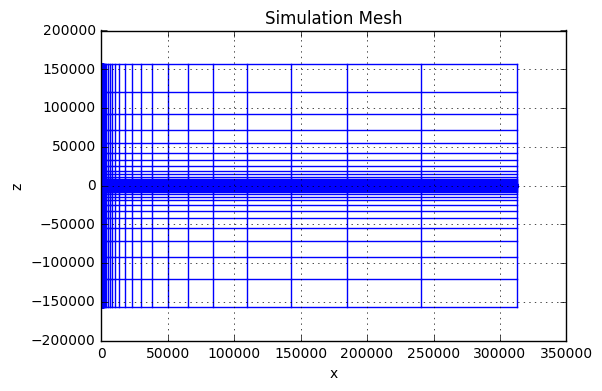

In [8]:
# X and Z limits we want to plot to. Try 
# xlim = np.r_[0., 2e6]
# zlim = np.r_[-2e6, 2e6]

fig, ax = plt.subplots(1,1)
mesh.plotGrid(ax=ax)

ax.set_title('Simulation Mesh')
# ax.set_xlim(xlim)
# ax.set_ylim(zlim)



## Put Model on Mesh

Now that the model parameters and mesh are defined, we can define electrical conductivity on the mesh. 

The electrical conductivity is defined at cell centers when using the finite volume method. So here, we define a vector that contains an electrical conductivity value for every cell center. 

In [9]:
# create a vector that has one entry for every cell center

def sigma(sig_background):
    sigma = sig_air*np.ones(mesh.nC)  # start by defining the conductivity of the air everwhere
    sigma[mesh.gridCC[:,2] < 0.] = sig_background  # assign halfspace cells below the earth

    # indices of the sphere (where (x-x0)**2 + (z-z0)**2 <= R**2)
    sphere_ind = (mesh.gridCC[:,0]**2 + (mesh.gridCC[:,2] - sphere_z)**2) <= sphere_radius**2 
    sigma[sphere_ind] = sig_sphere  # assign the conductivity of the sphere
    
    return sigma

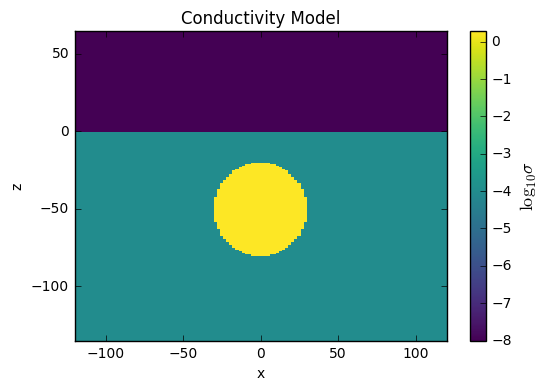

In [10]:
# Plot a cross section of the conductivity model
fig, ax = plt.subplots(1,1)
cb = plt.colorbar(mesh.plotImage(np.log10(sigma(sig_halfspace[1])), ax=ax, mirror=True)[0])

# plot formatting and titles
cb.set_label('$\log_{10}\sigma$', fontsize=13)
ax.axis('equal')
ax.set_xlim([-120., 120.])
ax.set_ylim([-100., 30.])
ax.set_title('Conductivity Model')



## Set up the Survey

Here, we define sources and receivers. For this example, the receivers are magnetic flux recievers, and are only looking at the secondary field (eg. if a bucking coil were used to cancel the primary). The source is a vertical magnetic dipole with unit moment. 

In [11]:
# Define the list of sources - one source for each frequency. The source is a point dipole oriented
# in the z-direction

srcList = [TDEM.Src.MagDipole([], loc=src_loc, orientation='Z', waveform=TDEM.Src.StepOffWaveform())]


## Set up Forward Simulation 

A forward simulation consists of a paired SimPEG problem and Survey. For this example, we use the E-formulation of Maxwell's equations, solving the second-order system for the electric field, which is defined on the cell edges of the mesh. This is the `prob` variable below. The `survey` takes the source list which is used to construct the RHS for the problem. The source list also contains the receiver information, so the `survey` knows how to sample fields and fluxes that are produced by solving the `prob`.



**An Aside: Mappings** 

The `sigmaMap` defines a [mapping](http://dev-docs.simpeg.xyz/content/api_core/api_Maps.html) which translates an input vector to a physical property - specifically, $\sigma$. This comes in handy when you want to invert for $\log(\sigma)$, in that case, the model is defined in terms of log-conductivity, and you would need an `ExpMap` to translate $\log(\sigma) \to \sigma$

In [57]:
# define a problem - the statement of which discrete pde system we want to solve
prob = TDEM.Problem3D_e(mesh, sigmaMap=Maps.IdentityMap(mesh))  
prob.timeSteps = [(1e-6, 10)]
prob.solver = Solver

survey = TDEM.Survey(srcList)

# tell the problem and survey about each other - so the RHS can be constructed for the problem and the
# resulting fields and fluxes can be sampled by the receiver. 
prob.pair(survey)  

In [58]:
prob.timeMesh.gridN

array([  0.00000000e+00,   1.00000000e-06,   2.00000000e-06,
         3.00000000e-06,   4.00000000e-06,   5.00000000e-06,
         6.00000000e-06,   7.00000000e-06,   8.00000000e-06,
         9.00000000e-06,   1.00000000e-05])

### Solve the forward simulation 

Here, we solve the problem for the fields everywhere on the mesh.

In [59]:
%%time

fields = {}
for sig_half in sig_halfspace:
    fields[sig_half] = prob.fields(sigma(sig_half))

CPU times: user 4.66 s, sys: 324 ms, total: 4.98 s
Wall time: 2.71 s


### Plot the fields

Lets look at the physics!

In [60]:
# log-scale the colorbar
from matplotlib.colors import LogNorm 
import ipywidgets

In [61]:
prob.timeMesh.gridN[-3]

7.9999999999999996e-06

In [62]:
def plot_bSecondary(
    sig_ind=0, # which frequency would you like to look at?
    time=0
#     ax=ax
):
    fig, ax = plt.subplots(1,1, figsize=(6,5))
    
    # Plot the magnetic flux
    field_to_plot = fields[sig_halfspace[sig_ind]][: ,'b',time] 
    max_field = np.abs(field_to_plot).max() #use to set colorbar limits
    cb_range = 5e2  # dynamic range of colorbar
    
    cb = plt.colorbar(mesh.plotImage(
        field_to_plot, 
        vType='F', view='vec', 
        range_x=[-120., 120.], range_y=[-180., 80.],
        pcolorOpts={
                'norm': LogNorm(), 
                'cmap': plt.get_cmap('viridis')
            },
        streamOpts={'color': 'w'}, mirror=True, ax=ax, 
        clim=[max_field/cb_range, max_field]
    )[0], ax=ax)

    ax.set_xlim([-120., 120.])
    ax.set_ylim([-180., 70.])
    cb.set_label('|B|')

    # plot the outline of the sphere
    x = np.linspace(-sphere_radius, sphere_radius, 100)
    ax.plot(x, np.sqrt(sphere_radius**2 - x**2) + sphere_z, color='k')
    ax.plot(x, -np.sqrt(sphere_radius**2 - x**2) + sphere_z, color='k')

    # plot the source and receiver locations
    ax.plot(src_loc[0],src_loc[2],'co', markersize=6)
    # ax.plot(rx_loc[0,0],rx_loc[0,2],'co', markersize=6)

    # plot the surface of the earth
    ax.plot(np.r_[-200, 200], np.r_[0., 0.], 'w:')

    # give it a title
    ax.set_title(
        'B, {background:1.1e} S/m, {time:1.1e}'.format(
            background=sig_halfspace[sig_ind], 
            time=prob.timeMesh.gridCC[time]
        )
    )
    plt.show()
    return ax

ipywidgets.interact(
    plot_bSecondary, 
    sig_ind=ipywidgets.IntSlider(min=0, max=len(sig_halfspace)-1, value=0), 
    time=ipywidgets.IntSlider(min=0, max=prob.timeMesh.nC, value=0), 
)

ValueError: Data has no positive values, and therefore can not be log-scaled.

<function __main__.plot_bSecondary>

ValueError: values must all be positive

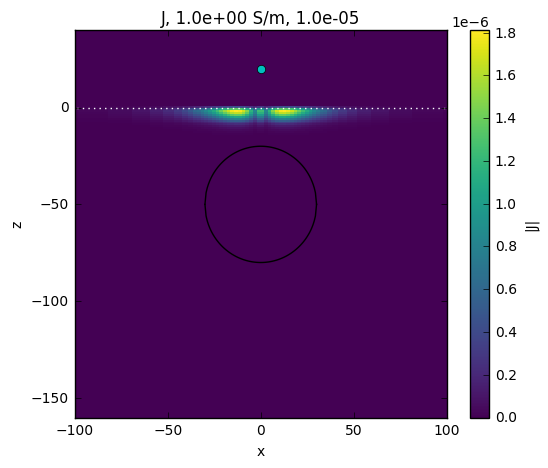

In [63]:
def plot_j(
    sig_ind=0, # which frequency would you like to look at?
    time=0  # time index
#     ax=ax
):
    fig, ax = plt.subplots(1,1, figsize=(6,5))
    
    # Plot the current density 
    field_to_plot = np.absolute(fields[sig_halfspace[sig_ind]][:, 'e', time])
    aveE2CCV = mesh.aveE2CCV
    # number of components (instead of checking if cyl or not)
    n = int(aveE2CCV.shape[0] / mesh.nC)
    VI = Utils.sdiag(np.kron(np.ones(n), 1./mesh.vol)) 
    field_to_plot = VI * (
                aveE2CCV * (mesh.getEdgeInnerProduct(sigma(sig_halfspace[sig_ind])) * field_to_plot)
            )
    
    max_field = np.abs(field_to_plot).max() #use to set colorbar limits
    cb_range = 5e2  # dynamic range of colorbar
    
    cb = plt.colorbar(mesh.plotImage(
        field_to_plot, 
        vType='CCv', 
        range_x=[-120., 120.], range_y=[-180., 80.],
        pcolorOpts={
#                 'norm': LogNorm(), 
                'cmap': plt.get_cmap('viridis')
            },
        streamOpts={'color': 'w'}, mirror=True, ax=ax, 
#         clim=[max_field/cb_range, max_field]
    )[0], ax=ax)
    
    cb.formatter.set_scientific(True)
    cb.formatter.set_powerlimits((0, 0))
    cb.update_ticks()
#     cb.formatter.format(style='sci', scilimits=(0,0))

    ax.set_xlim([-100., 100.])
    ax.set_ylim([-160., 40.])
#     ax.axis('equal')
    cb.set_label('|J|')

    # plot the outline of the sphere
    x = np.linspace(-sphere_radius, sphere_radius, 100)
    ax.plot(x, np.sqrt(sphere_radius**2 - x**2) + sphere_z, color='k')
    ax.plot(x, -np.sqrt(sphere_radius**2 - x**2) + sphere_z, color='k')

    # plot the source and receiver locations
    ax.plot(src_loc[0],src_loc[2],'co', markersize=6)
    # ax.plot(rx_loc[0,0],rx_loc[0,2],'co', markersize=6)

    # plot the surface of the earth
    ax.plot(np.r_[-200, 200], np.r_[0., 0.], 'w:')

    # give it a title
    ax.set_title(
        'J, {background:1.1e} S/m, {time:1.1e}'.format(
            background=sig_halfspace[sig_ind],
            time=prob.timeMesh.gridN[time]
        )
    )
    plt.show()
    return ax

ipywidgets.interact(
    plot_j, 
    sig_ind=ipywidgets.IntSlider(min=0, max=len(sig_halfspace)-1, value=0), 
    time=ipywidgets.IntSlider(min=0, max=prob.timeMesh.nN, value=0), 
    
)

In [69]:
from matplotlib import ticker

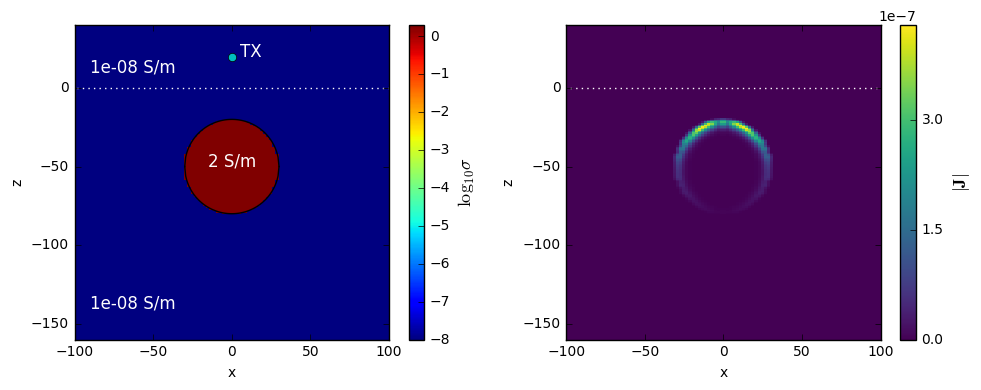

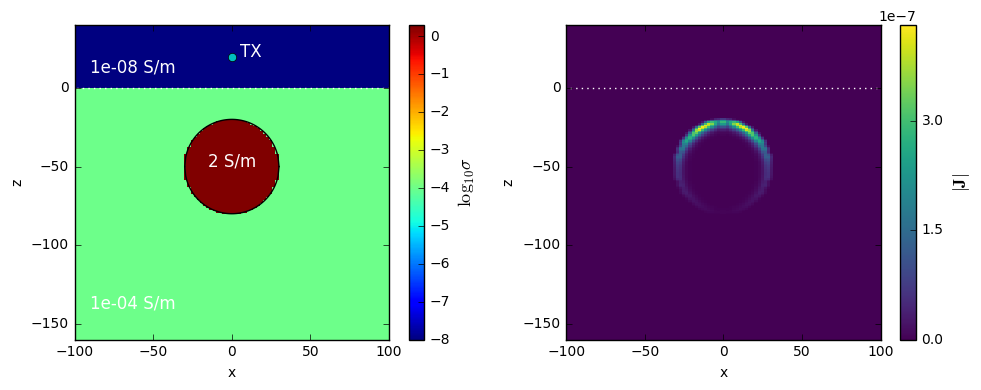

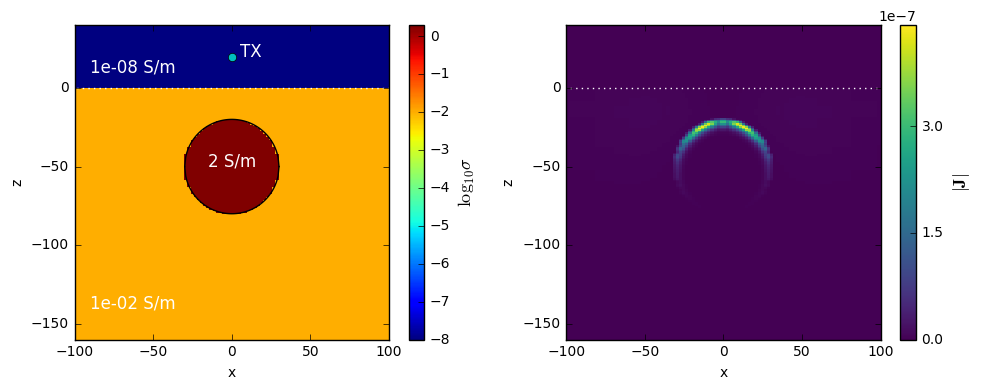

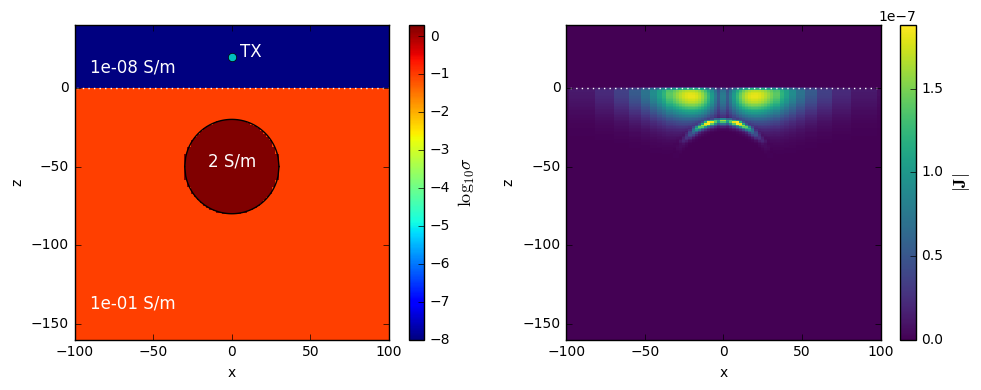

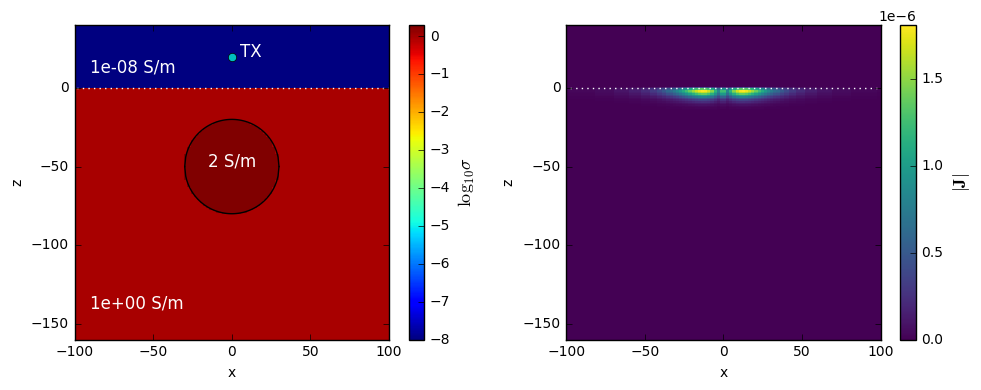

In [71]:
for sig_ind in range(len(sig_halfspace)):
    
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    
    cb0 = plt.colorbar(mesh.plotImage(
            np.log10(sigma(sig_halfspace[sig_ind])), ax=ax[0], mirror=True, pcolorOpts={
#                 'norm': LogNorm(), 
                'cmap': plt.get_cmap('jet'),
            },
    )[0], ax=ax[0])
    
    
    ax[0].annotate('TX', xy=np.r_[5, boom_height], xytext=np.r_[5, boom_height], fontsize=12, color='w')
    ax[0].annotate('{:1.0e} S/m'.format(sig_air), xy=np.r_[-90, 10], xytext=np.r_[-90, 10], fontsize=12, color='w')
    ax[0].annotate('{:1.0e} S/m'.format(sig_halfspace[sig_ind]), xy=np.r_[-90, -140], xytext=np.r_[-90, -140], fontsize=12, color='w')
    ax[0].annotate('{:1.0f} S/m'.format(sig_sphere), xy=np.r_[-15, sphere_z], xytext=np.r_[-15, sphere_z], fontsize=12, color='w')

    # plot formatting and titles
    cb0.set_label('$\log_{10}\sigma$', fontsize=13)
#     cb.locator =  ticker.MaxNLocator(nbins=5)
    
    # Plot the current density 
    field_to_plot = np.absolute(fields[sig_halfspace[sig_ind]][:, 'e', -1])
    aveE2CCV = mesh.aveE2CCV
    # number of components (instead of checking if cyl or not)
    n = int(aveE2CCV.shape[0] / mesh.nC)
    VI = Utils.sdiag(np.kron(np.ones(n), 1./mesh.vol)) 
    field_to_plot = VI * (
                aveE2CCV * (mesh.getEdgeInnerProduct(sigma(sig_halfspace[sig_ind])) * field_to_plot)
            )
    
    max_field = np.abs(field_to_plot).max() #use to set colorbar limits
    cb_range = 5e2  # dynamic range of colorbar
    
#     cb = plt.colorbar
    out = mesh.plotImage(
        field_to_plot, 
        vType='CCv', 
        range_x=[-120., 120.], range_y=[-180., 80.],
        pcolorOpts={
#                 'norm': LogNorm(), 
                'cmap': plt.get_cmap('viridis'),
            },
        streamOpts={'color': 'w'}, mirror=True, ax=ax[1], 
#         clim=[max_field/cb_range, max_field],
    )
    cb = plt.colorbar(out[0], ax=ax[1])
    
#     cb.formatter.set_scientific(True)
    cb.formatter.set_powerlimits((0, 0))
    cb.locator =  ticker.MaxNLocator(nbins=4)
#     cb.ax.format = '%1.1f'
    cb.update_ticks()
    
#     cb.formatter.format(style='sci', scilimits=(0,0))

#     ax.axis('equal')
    cb.set_label('$|\mathbf{J}|$', fontsize=13)
    
    for a in ax:

        a.set_xlim([-100., 100.])
        a.set_ylim([-160., 40.])
        # plot the outline of the sphere
        x = np.linspace(-sphere_radius, sphere_radius, 100)

        # plot the surface of the earth
        a.plot(np.r_[-200, 200], np.r_[0., 0.], 'w:')

    ax[0].plot(x, np.sqrt(sphere_radius**2 - x**2) + sphere_z, color='k')
    ax[0].plot(x, -np.sqrt(sphere_radius**2 - x**2) + sphere_z, color='k')

    # plot the source and receiver locations
    ax[0].plot(src_loc[0],src_loc[2],'co', markersize=6)
    # a.plot(rx_loc[0,0],rx_loc[0,2],'co', markersize=6)

    
    plt.tight_layout()    
    plt.show()
    fig.savefig('j_tdem_{}'.format(sig_ind), dpi=300)

KeyError: 1.0

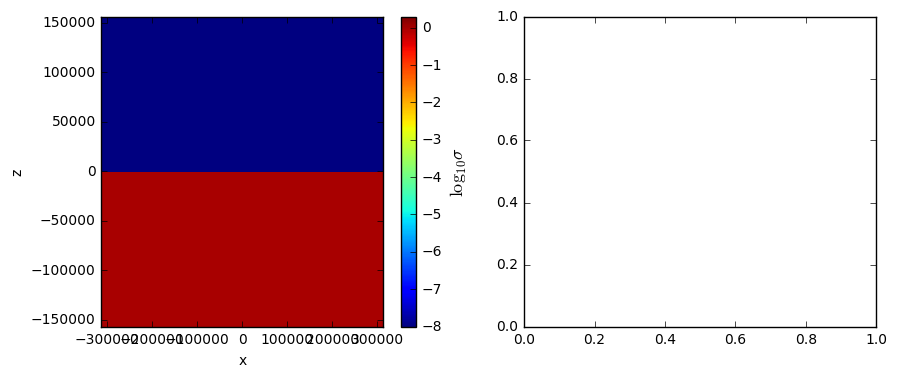

In [20]:
# for sig_ind in range(len(sig_halfspace)):
sig_ind=4
fig, ax = plt.subplots(1,2, figsize=(10,4))

cb0 = plt.colorbar(mesh.plotImage(
        np.log10(sigma(sig_halfspace[sig_ind])), ax=ax[0], mirror=True, pcolorOpts={
#                 'norm': LogNorm(), 
            'cmap': plt.get_cmap('jet'),
        },
)[0], ax=ax[0])
# plot formatting and titles
cb0.set_label('$\log_{10}\sigma$', fontsize=13)

# Plot the current density
field_to_plot = np.absolute(fields[sig_halfspace[sig_ind]][:, 'j'])
max_field = np.abs(field_to_plot).max() #use to set colorbar limits
cb_range = 5e2  # dynamic range of colorbar

#     cb = plt.colorbar
out = mesh.plotImage(
    field_to_plot, 
    vType='CCv', 
    range_x=[-120., 120.], range_y=[-180., 80.],
    pcolorOpts={
#                 'norm': LogNorm(), 
            'cmap': plt.get_cmap('viridis'),
        },
    streamOpts={'color': 'w'}, mirror=True, ax=ax[1], 
#         clim=[max_field/cb_range, max_field],
)
cb = plt.colorbar(out[0], ax=ax[1])

cb.formatter.set_scientific(True)
cb.formatter.set_powerlimits((0, 0))



# cb.ax.format = '%1.1f'
cb.update_ticks()

#     cb.formatter.format(style='sci', scilimits=(0,0))

#     ax.axis('equal')
cb.set_label('$|\mathbf{J}|$', fontsize=13)

for a in ax:

    a.set_xlim([-100., 100.])
    a.set_ylim([-160., 40.])
    # plot the outline of the sphere
    x = np.linspace(-sphere_radius, sphere_radius, 100)
    a.plot(x, np.sqrt(sphere_radius**2 - x**2) + sphere_z, color='k')
    a.plot(x, -np.sqrt(sphere_radius**2 - x**2) + sphere_z, color='k')

    # plot the source and receiver locations
    a.plot(src_loc[0],src_loc[2],'co', markersize=6)
    # a.plot(rx_loc[0,0],rx_loc[0,2],'co', markersize=6)

    # plot the surface of the earth
    a.plot(np.r_[-200, 200], np.r_[0., 0.], 'w:')


plt.tight_layout()    
plt.show()


In [ ]:
from matplotlib import ticker

### Take the ratio with the primary field

If simulating a DIGHEM survey, for example, the data are provided as the ratio of the secondary field with the primary as measured at the receiver in free space. 

In what follows, we set calculate the primary field at the receiver, calcuate the secondary magnetic fields measured by the receiver (**dpred**) and then take the ratio with the primary. 

In [132]:
# Primary Field at receiver
rx = rxList[0]
P = rx.getP(mesh, 'Fz')
bprimary = fields[srcList[1], 'bPrimary']
b0 = P*bprimary
b0 = b0[0][0].real

IndexError: list index out of range

In [173]:
cb.formatter.format_data?

In [20]:
# reshape the data vector by sources and receivers
dpred_reshaped = dpred.reshape((len(rxList), len(srcList)), order='F').T
dpred_real = dpred_reshaped[:,0]
dpred_imag = dpred_reshaped[:,1]

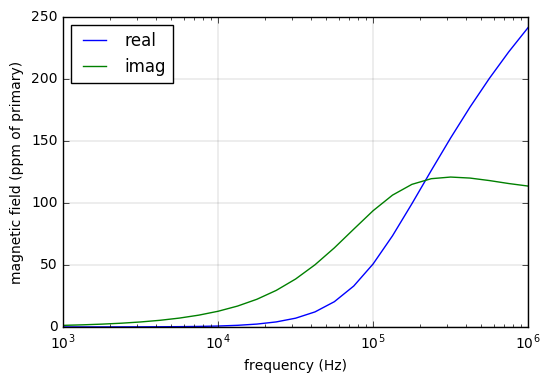

In [22]:
# Plot
fig, ax = plt.subplots(1,1)

ax.semilogx(freqs, dpred_real/b0*1e6)
ax.semilogx(freqs, dpred_imag/b0*1e6)
ax.grid(True, color='k',linestyle="-", linewidth=0.1)

ax.legend(['real','imag'], loc='best')
# ax.set_title('Sounding over Sphere')
ax.set_ylabel('magnetic field (ppm of primary)')
ax.set_xlabel('frequency (Hz)')